# Working with symbolic expressions

## Contents
+ Modeling algebraic expressions as data structures
+ Writing code to analyze, transform, or evaluate algebraic expressions
+ Finding the derivative of a function by manipulating the expression that defines it
+ Writing a Python function for automatic derivatives
+ Using *SymPy* library for automatic integrals

## Introduction

In the previous chapters we've used Python to approximate solutions for two of the most important concepts in calculus: derivatives and integrals. 

We learned to calculate derivatives by taking slopes of smaller and smaller secant lines, and to calculate integrals by estimating the area under a graph with thinner and thiner rectangles.

By using that *programmatic* approach, we've been able to work do very interesting applications without following the *formal* approach first.

That *formal* (non-programmatic) approach dictates how to calculate the exact formula for a derivative and integral.
For example, if $ f(x) = x^3 $, $ f'(x) = 3x² $.

### Finding an exact derivative with a computer algebra system

While knowing the rules for derivatives and integrals are very important for Math purposes, those are actually not that useful for computing.

In case you need to know the exact formula for a derivative, you can always rely on a *computer algebra system* like *Mathematica*. In particular, there are tools online such as [wolframalpha.com](https://www.wolframalpha.com/), which are powered by *Mathematica* engine.

For instance:

![Wolfram Alpha](../images/wolfram_alpha.png)

This will obviously will work for more complicated formulas such as:

$
\displaystyle
f(x) = \frac{1}{1 + e^{-x}}
$

Which would be written in Python as: `1/(1 + e**(-x))` can be punched into [wolframalpha.com](https://www.wolframalpha.com/) to obtain:

$
\displaystyle
f(x) = \frac{e^{-x}}{(1 + e^{-x})^2}
$

In short, from a programmer's POV, it is more important to know that the derivative represents the instantaneous rate of change of a given function, and know that you have tools such as [wolframalpha.com](https://www.wolframalpha.com/) to obtain the derivative that remembering all the derivative rules by heart.

Note that *Mathematica* does not use the approximation approach we've been learning in the past chapters. Instead, it leverages a technique called *symbolic programming* to come up with the formulas.

In this chapter, we will learn how to do some *symbolic programming* in Python to manipulate algebraic formulas directly, and ultimately figure out the formulas for the derivatives.

### Doing symbolic algebra in Python

When representing a mathematical formula in Python using the common representation we've used until now, which consists in defining a Python function, does not let us obtain a lot of introspection info about the formula itself:

```python
from math import sin

def f(x):
    return (3 * x ** 2 + x) * sin(x)
```

We can use the representation above to calculate data points, and plot the function, but that representation will make it very difficult for us to create a function such as `contain_division(f)` that would return `False` in the case above.

In order to solve such questions we need to represent the function as a *data structure* that would help us understand the algebraic expression that defines the function at a deeper level than the Python function does, while also give us a chance to manipulate it (for example to expand the product).

> Our goal for the chapter is to build a program that takes an algebraic expression and transforms it into a data structure that can represent variables, numbers, sums, differences, products, quotients, powers and special functions such as the sine and cosine. With that, we will also allow the generation of derivatives for all of them.

## Modeling algebraic expressions

Let's consider the function $ f(x) = (3x² + x) \cdot sin(x) $. This is a good candidate for finding the correct modeling approach because it contains variables, numbers, addition and multiplication, a power and special functions such as *sine*.

The first note is that the function name $ f $ is an arbitrary name and does not affect the definition of the function. Thus, we can focus on the right-hand side of the equation.

> The right hand side of an equation is called an *expression* &mdash; a collection of mathematical symbols combine in some valid way.

### Breaking an expression into pieces

Now that it's clear that we will be focusing in $ (3x² + x) \cdot sin(x) $, we need to break this expression into smaller pieces.

To properly break that expression, we need to split it by the $ \cdot $ operator:

![Breaking up an algebraic expression](../images/breaking_up_expression.png)



Likewise, $ 3x² + x $ can be broken down into the sum of $ 3x² $ and $ x $. And $ 3x^2 $ can be further decomposed into the product of $ 3 $ and $ x^2 $.

In the terminology of functional programming, functions combining smaller objects into bigger ones are often called *combinators*. The ones that we've found in our *alebraic expression* are:
+ $ 3x² $ is the product of the expressions $ 3 $ and $ x^2 $
+ $ x^2 $ is a power: the expression $ x $ raised to the power of another expression $ 2 $.
+ The expression $ sin(x) $ is a function application &mdash; given the expression $ sin $ and the expression $ x $, we build a new expression $ sin(x) $.

A variable like $ x $, a number like $ 2 $ or a function name like $ sin $ can't be broken down further. To distinguish those from *combinators* we call them *elements*.

### Building an expression tree

The elements and combinators we find in the *algebraic expression* $ (3x² + x) \cdot sin(x) $, along with the concept of applying a function, are sufficient to rebuild the expression as a tree. Let's see how, first manually.

We can start with $ x^2 $, which combines the elements $ x $ and $ 2 $ with the power combinator.

That can be followed by the product of $ 3 $ and $ x^2 $, and so forth until we end up with a whole tree that represents the *algebraic expression* as seen below:

![Building the expression tree](../images/expression_tree_sequence.png)

The root of the tree is the product combinator we used in the previous subsection. From that root node, we create two branches and recursively start creating additional branches that represent the expression.

### Translating the expression tree to Python

In this section we will build some classes representing the expression as a data structure. We will start simple, and start adding more and more capabilities along the way until we reach our goal.


In our implementation, we will model combinators as containers that hold their inputs.

For example:

In [ ]:
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

We also need classes to represent numbers and variables, as those will give us extra flexibility in the implementation:

In [ ]:
class Number():
    def __init__(self, number):
        self.number = number

class Variable():
    def __init__(self, symbol):
        self.symbol = symbol

In [ ]:
With these three classes defined, we will be able to define our first algebraic expression:

In [1]:
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

class Number():
    def __init__(self, number):
        self.number = number

class Variable():
    def __init__(self, symbol):
        self.symbol = symbol

Power(Variable('x'), Number(2))        

Now let's address the `Product` class:

In [ ]:
class Product():
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2

With that, we can now model expressions such as $ 3 \cdot x^2 $:

In [2]:
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

class Number():
    def __init__(self, number):
        self.number = number

class Variable():
    def __init__(self, symbol):
        self.symbol = symbol

class Product():
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2

Product(Number(3), Power(Variable('x'), Number(2)))

After that, we're in a good position to have our first implementation of our algebraic expression classes that would represent the expression:

$$
\displaystyle
(3x² + x) \cdot sin(x)
$$

In [5]:
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

class Number():
    def __init__(self, number):
        self.number = number

class Variable():
    def __init__(self, symbol):
        self.symbol = symbol

class Product():
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2

class Sum():
    def __init__(self, *exprs):
        self.exprs = exprs

class Function():
    def __init__(self, name):
        self.name = name

class Apply():
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument

#  (3x² + x) · sin(x)
expression = Product(
    Sum(
        Product(
             Number(3),
             Power(
                 Variable('x'), 
                 Number(2))), 
        Variable('x')),
    Apply(
        Function('sin'), 
        Variable('x')))        

With those simple classes we have given the first step for the creation of our *algebraic expression engine*. Note that despite having been created for a particular expression, the approach is quite flexible as other expressions such as:

```python
Apply(Function("cos"),Sum(Power(Variable("x"),Number("3")), Number(-5)))
```

faithfully represent other *algebraic expressions* such as:

$$
\displaystyle
cos(x^3 - 5)
$$

## Putting a symbolic expression to work

We've seen that for the function we've considered: $ f(x) = (3x² + x)sin(x) $, we can define a Python function that is good for returning an output value:

```python
def f(x):
    return (3 * x ** 2 + x) * sin(x)
```

but it is not useful for obtaining insights about the function itself (as in: does it use a trigonometric function?) or to expand the expression (as in $ f(x) = 3x^2 sin(x) + x sin(x) $).

Then, we created a series of *element* and *combinator* classes, but those seem to be like two separate worlds.

The goal of this section is to bridge the gap, so that we can interact with the expression as a data structure of *elements* and *combinators* and also obtain the value when needed.

## 10.2.1 Finding all the variables in an expression

Let's write a function that takes an expression and returns a list of distinct variables that appear in it.

For example, $ h(z) = 2z + 3 $ should find `z` while $ g(x) = 7 $ should find no variables.

We will call this function `distinct_variables(expr)` and it will accept any expression and return a Python set containing the variables found.

As you can imagine the situation becomes really complicated when the expression is built from combinators as in $ y \cdot z + x \cdot z $.

We have already established that the resulting structure that represents that expression is a tree:

```python
Sum(
    Product(
        Variable('y'), 
        Variable('z')
        ),
    Product(
        Variable('x'), 
        Variable('z'))
)
```

Trees being recursive structures, it seems that it would be appropriate to traverse the expression using a recursive function.

In [5]:
from my_expressions_v2 import *

expr = Sum(
    Product(
        Variable('y'), 
        Variable('z')
        ),
    Product(
        Variable('x'), 
        Variable('z'))
)

def distinct_variables(expr):
    if isinstance(expr, Variable):
        return set(expr.symbol)
    elif isinstance(expr, Number):
        return set()
    elif isinstance(expr, Sum):
        return set().union(*[distinct_variables(inner_expr) for inner_expr in expr.exprs])
    elif isinstance(expr, Product):
        return distinct_variables(expr.expr1).union(distinct_variables(expr.expr2))
    elif isinstance(expr, Power):
        return distinct_variables(expr.base).union(distinct_variables(expr.exponent))
    elif isinstance(expr, Apply):
        return distinct_variables(expr.argument)
    else:
        raise TypeError('Not a valid expression')

distinct_variables(expr)


{'x', 'y', 'z'}

That is nothing more than a recursive traversal of a tree. When the function completes, it would have called `distinct_variables(...)` on every expression contained in the target expression.

The same approach can be used to find all of the numbers or all of the functions in an expression.

### Evaluating an expression

Now, we've got two representation of the same mathematical function $ f(x) $. The Python function that let us evaluate the function at a given input value of $ x $, and the tree data structure that describes the structure of the expression defining $ f(x) $.

We will see that the latter is also a good option to evaluate $ f(x) $ as well with a little bit of extra work.

*Mechanically*, evaluating the function $ f(x) $ at $ x = 5 $ means substituting the value $ 5 $ everywhere where $ x $ is found in the expression (which could be nowhere if the function is $ g(x) = 7 $).

We just need to code the same behavior we have just described: we need to find all the variables, *plug in* the given value for those, and then add some intelligence to the combinators so that they provide the value of the expression they hold.

The starting data we need are the values to plug-in along with the variable names that they replace. That is, in programming terms, we need to know the *variable bindings*.

For example, to evaluate the function $ z(x, y) = 2xy^3 $ we will need some variable bindings such as $ x = 3 $ and $ y = 2 $.

With the bindings in place, it will be easy to compute $ x(3, 2) = 2 \cdot 3 \cdot 2^3 $.

In this case, instead of using the previous approach in which we created a function that obtained the final result, we will add an `evaluate(...)` method to each class that represents an expression.

In order to enforce this, we will define this method at the `Expression` base abstract class level first:

```python
class Expression(ABC):
    @abstractmethod
    def evaluate(self, **bindings):
        pass
```

Note that the function allows you to pass a variable number of bindings, to support expressions with more than one variable.

Our expectation, is that the consumer application will use this function like:

```python
z.evaluate(x=3, y=2) // will do the evaluation for those bindings
```

Now, we need to modify the `Expression` subclasses to implement the `evaluate(...)` method.


The number class is the easiest one, as it should simply return the underlying number.

```python
class Number(Expression):
    def __init__(self, number):
        self.number = number

    def evaluate(self, **bindings):
        return self.number
```

The `Variable` class is a bit trickier, as we will need to do the substitution:

```python
class Variable(Expression):
    def __init__(self, symbol):
        self.symbol = symbol

    def evaluate(self, **bindings):
        try:
            return bindings[self.symbol]
        except:
            raise KeyError('Variable {} is not bound'.format(self.symbol))
```

The only interesting part here is the way in which we can *plug-in* the values in Python:

Let's consider the following function and invocation

In [6]:
def f(**args):
    print(args)


f(x=1, y=2, z=3)

{'x': 1, 'y': 2, 'z': 3}


Note how the invocation of `f(...)` with the given args end up passing the function a dictionary `{'x': 1, 'y': 2, 'z': 3}`, which we can access using the syntax:

```python
args[key] // => value
```

Thus:

```python
binding[self.symbol]
```
will actually get the value in the dictionary for the given variable name.

Now, we need to turn our attention to the combinators. Note that we won't consider the `Function` object just yet.

The rule is simple: evaluate both expressions contained in the product and then multiply them together.

For example, for `Product`:

```python
class Product(Expression):
class Product(Expression):
    def __init__(self, expr1, expr2):
        self.expr1 = expr1
        self.expr2 = expr2

    def evaluate(self, **bindings):
        return self.expr1.evaluate(**bindings) * self.expr2.evaluate(**bindings)
```

In the same way, we can add evaluate to the `Sum`, `Power`, `Difference`...

The `Apply` combinator works a bit differently, because we need to dynamically look at the function name and figure out how to compute its value.

For example, we can create a dictionary and then apply it to the evaluation of the argument of the function:

```python
_function_bindings = {
    'sin': math.sin,
    'cos': math.cos,
    'ln': math.log
    /* ... more functions as needed ... */
}

class Apply(Expression):
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument

    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))
```

After applying those changes, we can start doing evaluations of our previously defined algebraic expressions:

In [5]:
from my_expressions_v2 import *
from math import sin

expr1 = Product(Variable('x'), Variable('y')).evaluate(x=2, y=5)
print(expr1) # should be 10

f_expression = Product(
    Sum(
        Product(
             Number(3),
             Power(
                 Variable('x'), 
                 Number(2))), 
        Variable('x')),
    Apply(
        Function('sin'), 
        Variable('x')))

result = f_expression.evaluate(x=5)
print(result)

def f(x):
    return (3 * x ** 2 + x) * sin(x)

print(f(5))

10
-76.71394197305108
-76.71394197305108


### Expanding an expression

Once we have our algebraic expression represented as a tree structure we can do further manipulation with it. For example, we can try expanding an expression using the *distributive property* of sums and products.

This rule says that:

$
\displaystyle
(a + b) \cdot c = a \cdot c + b \cdot c
$

Therefore, our expression:

$
\displaystyle
(3 x^2 + x) sin(x) = 3 x^2 sin(x) + x sin(x)
$

The same rule can also be used to expand more complex expressions:

$
\displaystyle
(x + y)^3 = (x + y)(x + y)(x + y) = \\
x(x + y)(x + y) + y(x + y)(x + y) = \\
x^2(x + y) + xy(x + y) + xy(x + y) + y^2(x + y) = \\
x^3 + x^2y + x^2y + xy^2 + x^2y + xy^2 + xy^2 + y^3 = \\
x^3 + 3x^2y + 3xy^2 + y^3
$

The way to do it programmatically consists in defining an `expand(...)` method, first to the `Expression` base class, and then cascade the implementation of the `expand()` to the different *elements* and *combinators*:

```python
class Expression(ABC):
...
    @abstractmethod
    def expand(self):
        pass

```

If an expression is a variable or number, it is already expanded, so the method should just return the object itself:

```python
class Number(Expression):
...
    def expand(self):
        return self

class Variable(Expression):
...
    def expand(self):
        return self
```

For sums, we just need to invoke `expand()` on each of its terms:

```python
class Sum(Expression):
...
    def expand(self):
        return Sum(*[expr.expand() for expr in self.exprs])

```

The same approach can be used for `Apply`:

```python
class Apply(Expression):
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument

    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))

    def expand(self):
        return Apply(self.function, self.argument.expand())
```

The real complexity is found when implementing this function in products or powers, because the structure of the expression changes completely.

Let's focus on the `Product` first. In order to handle it correctly, we need to differentiate three possible cases:
1. The first term of the product is the sum as in $ (a + b) \cdot c $
2. The second term of the product is the sum as in $ a \cdot (b + c) $
3. Neither of the terms is a sum, as in $ a \cdot b $

```python

class Product(Expression):
...
    def expand(self):
        expanded1 = self.expr1.expand()
        expanded2 = self.expr2.expand()
        if isinstance(expanded1, Sum):
            return Sum(*[Product(expr, expanded2).expand() for expr in expanded1.exprs])
        elif isinstance(expanded2, Sum):
            return Sum(*[Product(expanded1, expr) for expr in expanded2.exprs])
        else:
            return Product(expanded1, expanded2)
```

With all these methods implemented, we can then test our `expand()` function and see it correctly expands expressions such as $ (a + b)(x + y) $ and $ (3x^2 + x)sin(x) $.

At this point, we've written some Python functions that do algebra in the same way we do it manually. This area of computer science is called *symbolic programming* or *computer algebra*.

In [ ]:
For example, once we implement the exercises that let us display our expressions we can do:

In [1]:
from my_expressions_v2 import *

Product(
    Sum(Variable('a'), Variable('b')),
    Sum(Variable('x'), Variable('y'))
).expand()

Sum(Sum(Product(Variable('a'), Variable('x')), Product(Variable('a'), Variable('y'))), Sum(Product(Variable('b'), Variable('x')), Product(Variable('b'), Variable('y'))))

In [1]:
from my_expressions_v2 import *

# $ (3x^2 + x)sin(x) $.
Product(
    Sum(
        Product(
            Number(3),
            Power(Variable('x'), Number(2))
        ),
        Variable('x')
    ),
    Apply(Function('sin'), Variable('x'))
)


Product(Sum(Product(Number(3), Power(Variable('x'), Number(2))), Variable('x')), Apply(Function('sin'), Variable('x')))

## Finding the derivative of a function

There is often a *clean* algebraic formula for the derivative of a function. For instance, if $ f(x) = x^3 $, then, its derivative, which measures the instantaneous rate of change in f at any point $ x $ is given by the formula:

$
f'(x) = 3 \cdot x^2
$

Therefore, you can get the exact result by doing: $ f'(2) = 12 $.

### Derivative of powers

It doesn't require any calculus to find that the derivative of a function of the form $ f(x) = mx + n $ is $ f'(x) = m $. This is because the slope of any secant of the line is the same as the slope of the line.

| REMINDER: |
| :-------- |
| The slope of a function is defined as the change in the vertical coordinate divided by the change in the horizontal coordinate. |

This is intuitive, as a linear function $ f(x) $ changes at a constant rate with respect to its input, so the derivative is a constant function.

Note also that the constant $ n $ has no effect in the slope, and therefore, doesn't appear in the derivative function.

It turns out that the derivative of a quadratic function is a linear function. For example, if $ q(x) = x^2 $, $ q'(x) = 2x $. This also makes sense when you plot the graph of $ q(x) $.

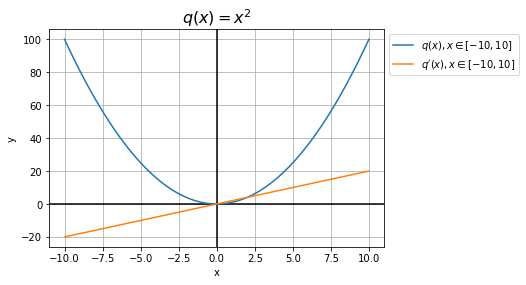

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.title(
    r'$q(x) = x^2 $', fontsize=16)
ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

# plotting the volume
def q(x):
    return x ** 2

def q_derivative(x):
    return 2 * x

xs = np.linspace(-10, 10, 100)
plt.plot(xs, q(xs), label=r'$ q(x), x \in [-10, 10] $')
plt.plot(xs, q_derivative(xs), label=r'$ q^\prime(x), x \in [-10, 10] $')

plt.xlabel(r'x')
plt.ylabel(r'y')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

As you can see, the slope starts negative, eventually becomes zero, and then turns positive.

All of these facts are special cases of the general rule:

$
\displaystyle
f(x) = a \cdot x^n \\
f'(x) = n \cdot a \cdot x^n
$

As an example:

$ 
f(x) = 5x^4 \\
f'(x) = 20x^3
$


### Derivatives of transformed functions

Adding a constant to a function never changes its derivative:

$
f(x) = x^100 + \pi \\
f'(x) = 100 x^99
$

However, some modifications of a functions change the derivative. For example, if you put a negative sign in front of a function, the graph flips upside down and so does the graph of any secant line.

Because derivatives are determined by the slopes of secant line, the derivative of a negative function is equal to the negative derivative. For example:

$
f(x) = -5x^2 \\
f'(x) = -10x
$


Similarly, if you multiply any function by a positive number (say 4), you will get a function that is 4 times steeper than the original one.

The derivative of the $ sin(x) $ is $ cos(x) $, and in particular:

$
f(x) = a \cdot sin(x) \\
f'(x) = a \cdot cos(x)
$

If you add two functions together, the vertical change for any secant line will be the sum of the vertical changes of the individual functions, and therefore:

$
h = f + g \\
h'(x) = f'(x) + g'(x)
$

### Derivatives of some special functions

The following table lists the derivatives of the common functions, so that it can be used as a cheat sheet:

| Function name | Formula | Derivative |
| :------------ | :------ | :--------- |
| Sine | $ sin(x) $ | $ cos(x) $ |
| Cosine | $ cos(x) $ | $ -sin(x) $ |
| Exponential | $ e^x $ | $ e^x $ |
| Exponential (any base) | $ a^x $ | $ ln(a) \cdot a \cdot x $ |
| Natural Logarithm | $ ln(x) $ | $ \frac{1}{x} $ |
| Logarithm (any base) | $ log_{a}(x) $ | $ \frac{1}{ln(x) \cdot x} $ |


| NOTE: |
| :---- |
| Remember that you can always rely on https://www.wolframalpha.com/ |


The cheat sheet above can be used to figure out more complicated derivatives, for example:

$
\text{Let } f(x) = 6x + 2sin(x) + 5e^x \\
f'(x) = 6 + 2cos(x) + 5e^x
$

Note however that when functions are combined in different ways other than addition and subtraction, the rules above do not apply.

For example:

$
\text{Let } f(x) = sin(sin(x)) \\
f'(x) \ne cos(cos(x))
$

You can find in https://www.wolframalpha.com/ that $ f'(x) = cos(x)cos(sin(x)) $

### Derivatives of products and compositions

